In [1]:
from theano.sandbox import cuda

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [2]:
%matplotlib inline
from __future__ import division, print_function

In [3]:
import math
import numpy as np
import random
import sys

from numpy.random import normal
import matplotlib.pyplot as plt

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, Activation, merge, Flatten, Dropout, Lambda
from keras.layers import LSTM, SimpleRNN, TimeDistributed
from keras.models import Model, Sequential
from keras.layers.merge import Add, add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.constraints import nonneg
from keras.layers.convolutional import *
from keras import backend as K
from keras.utils.data_utils import get_file

Using Theano backend.


In [329]:
look_back = 14

In [330]:
def mllklh(args): # minus log-likelihood of gaussian
    var_t, eps2_t = args
    return 0.5*math.log(2*math.pi) + 0.5*K.log(var_t)  + 0.5*(eps2_t/var_t)

In [331]:
'''lag = 10

hdim = 1
    
inputs = [Input(shape=(1,), dtype='float32') for i in range(lag)]
    
Square = Lambda(lambda x:x*x, output_shape=(1,))

Di2h = Dense(hdim, activation=None)
Dh2h = Dense(hdim, activation=None, kernel_initializer='identity')

#hidden = ... CONSTANT ZERO TENSOR IN KERAS ?

e = Di2h(Square(inputs[0]))
hidden = e
for i in range(1,lag-1): # WARNING
    e = Di2h(Square(inputs[i]))
    #hidden = merge([e, Dh2h(hidden)], mode='sum')
    hidden = add([e, Dh2h(hidden)])
    
#predictions = Dense(len(chars), activation='softmax')(hidden)

predvar = Lambda(lambda x:K.abs(x)+0.000001, output_shape=(1,))([hidden]) # insure positive var
    
error = Lambda(mllklh, output_shape=(1,))([predvar,Square(inputs[-1])])

modelUNR = Model(inputs=inputs, outputs=error) # un-rolled model
    
def special_loss(dummy, errorterms):
        return errorterms

modelUNR.compile(optimizer=Adam(1e-3), loss=special_loss)'''

"lag = 10\n\nhdim = 1\n    \ninputs = [Input(shape=(1,), dtype='float32') for i in range(lag)]\n    \nSquare = Lambda(lambda x:x*x, output_shape=(1,))\n\nDi2h = Dense(hdim, activation=None)\nDh2h = Dense(hdim, activation=None, kernel_initializer='identity')\n\n#hidden = ... CONSTANT ZERO TENSOR IN KERAS ?\n\ne = Di2h(Square(inputs[0]))\nhidden = e\nfor i in range(1,lag-1): # WARNING\n    e = Di2h(Square(inputs[i]))\n    #hidden = merge([e, Dh2h(hidden)], mode='sum')\n    hidden = add([e, Dh2h(hidden)])\n    \n#predictions = Dense(len(chars), activation='softmax')(hidden)\n\npredvar = Lambda(lambda x:K.abs(x)+0.000001, output_shape=(1,))([hidden]) # insure positive var\n    \nerror = Lambda(mllklh, output_shape=(1,))([predvar,Square(inputs[-1])])\n\nmodelUNR = Model(inputs=inputs, outputs=error) # un-rolled model\n    \ndef special_loss(dummy, errorterms):\n        return errorterms\n\nmodelUNR.compile(optimizer=Adam(1e-3), loss=special_loss)"

In [332]:
#len(Xs), Xs[0].shape, modelUNR.predict([X[10:15,0] for X in Xs]).shape

In [333]:
#modelUNR.predict([X[50:60,0] for X in Xs])

In [334]:
#modelUNRV = Model(input=inputs, output=predvar)
#np.sqrt(modelUNRV.predict([X[50:60,0] for X in Xs])*255)

### RNN architecture : 2 models that share same weights

In [358]:
MatPlus = np.zeros((look_back-1,look_back))
MatPlus[:,1:] = np.eye(look_back-1)
#print(MatPlus)

MatMinus = np.zeros((look_back-1,look_back))
MatMinus[:,:-1] = np.eye(look_back-1)
#print(MatMinus)

In [ ]:
Dplus = Dense(look_back-1,
              weights=[MatPlus.T, np.zeros((look_back-1,))],
              input_dim=look_back)
Dplus.trainable = False

Dminus = Dense(look_back-1,
              weights=[MatMinus.T, np.zeros((look_back-1,))],
              input_dim=look_back)
Dminus.trainable = False

In [427]:
I = Input(shape=(look_back,1), dtype='float32')
I2 = Lambda(lambda x : K.square(x), output_shape=(look_back,1))(I)
rnn = SimpleRNN(return_sequences=True, unroll=False,
                units=1, input_shape=(look_back, 1),
                bias_constraint=nonneg(), # insure positive var
                kernel_constraint=nonneg(), # insure positive var
                recurrent_constraint=nonneg(), # insure positive var
                activation=None) 
O1 = rnn(I2)
O1f = Flatten()(O1)
O1m = Dminus(O1f)

V = Lambda(lambda x : K.sqrt(x), output_shape=(look_back,))(O1m) # get volatility

I2f = Flatten()(I2)
I2p = Dplus(I2f)

Errors = Lambda(mllklh, output_shape=(look_back-1,))([O1m,I2p])

Error = Lambda(lambda x : K.sum(x, axis=1), output_shape=(look_back-1,))(Errors)

modelT = Model(inputs=I, outputs=Errors) # training model

def special_loss(dummy, errorterms):
    return errorterms

modelT.compile(optimizer='adadelta', loss=special_loss)

modelV = Model(inputs=I, outputs=V) # simulation model

In [428]:
Dp.get_weights()[0].shape, Dp.get_weights()[1].shape

((10, 9), (9,))

In [429]:
I._keras_shape, I2._keras_shape, O1._keras_shape, O1f._keras_shape, V._keras_shape, Errors._keras_shape, Error._keras_shape

((None, 14, 1),
 (None, 14, 1),
 (None, 14, 1),
 (None, 14),
 (None, 14),
 (None, 13),
 (None, 13))

In [430]:
onearr = np.ones((2, look_back, 1)).astype('float32')
print(I2.eval({I:onearr}).shape)
print(O1.eval({I:onearr}).shape)
print(Errors.eval({I:onearr}).shape)
print(Error.eval({I:onearr}).shape)
print(modelT.predict(onearr).shape)
print(modelV.predict(onearr).shape)

(2, 14, 1)
(2, 14, 1)
(2, 13)
(2,)
(2, 13)
(2, 13)


In [431]:
rnn(I2).eval({I:onearr}) # dry run to allow weight setting
rnn.set_weights([np.array([[0.5]]),np.array([[1]]),np.array([1.5])])
print( O1f.eval({I:onearr}) )
print( O1m.eval({I:onearr}) )

[[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.]
 [  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.]]
[[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.]
 [  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.]]


In [432]:
#print( I2f.eval({I:onearr}) )
#print( I2p.eval({I:onearr}) )

In [433]:
#model.predict(onearr).shape
Error.eval({I:onearr}).shape

(2,)

In [434]:
'''It = Input(shape=(look_back,1), dtype='float32')
RNNt = SimpleRNN(activation=None, return_sequences=True, unroll=False, units=1, input_shape=(look_back, 1))

RNNt(It).eval({It:onearr}) # dry run to allow weight setting

RNNt.set_weights([np.array([[0.5]]),np.array([[1.]]),np.array([3.])])
RNNt(It).eval({It:onearr})'''

"It = Input(shape=(look_back,1), dtype='float32')\nRNNt = SimpleRNN(activation=None, return_sequences=True, unroll=False, units=1, input_shape=(look_back, 1))\n\nRNNt(It).eval({It:onearr}) # dry run to allow weight setting\n\nRNNt.set_weights([np.array([[0.5]]),np.array([[1.]]),np.array([3.])])\nRNNt(It).eval({It:onearr})"

In [435]:
#RNNt.states

In [436]:
modelT.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_43 (InputLayer)            (None, 14, 1)         0                                            
____________________________________________________________________________________________________
lambda_112 (Lambda)              (None, 14, 1)         0                                            
____________________________________________________________________________________________________
simple_rnn_33 (SimpleRNN)        (None, 14, 1)         3                                            
____________________________________________________________________________________________________
flatten_33 (Flatten)             (None, 14)            0                                            
___________________________________________________________________________________________

#### Manually specify a GARCH model

In [437]:
kappa = 0.000003
alpha = 0.45
beta = 0.45
lvar = kappa / (1-alpha-beta)
print(math.sqrt(lvar)*math.sqrt(255))

0.0874642784227


#### Copy the known GARCH parameters as initial weights for the RNN

In [1092]:
math.sqrt(lvar) # standard deviation of simulated data set

0.00547722557505166

In [1093]:
F = 1/math.sqrt(lvar) # will have to scale training data by F and Kappa by F^2 (alpha and beta unchanged)

In [1094]:
rnn(I2).eval({I:onearr}) # dry run to allow weight setting
rnn.set_weights([np.array([[beta]]),np.array([[alpha]]),np.array([kappa])*F*F*1.20])

#### Simulate the GARCH dynamic

In [1095]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

train = []
trainvars = []
var_t = lvar
for t in range(250*8):
    eps = math.sqrt(var_t) * normal()
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    train.append(eps) # percent
    trainvars.append(var_t)
train = np.array(train).reshape(-1,1)
trainX, trainY = create_dataset(train, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#print(trainX, trainY)

In [1096]:
trainX.shape, trainY.shape, trainX.transpose((0,2,1)).shape

((1985, 1, 14), (1985,), (1985, 14, 1))

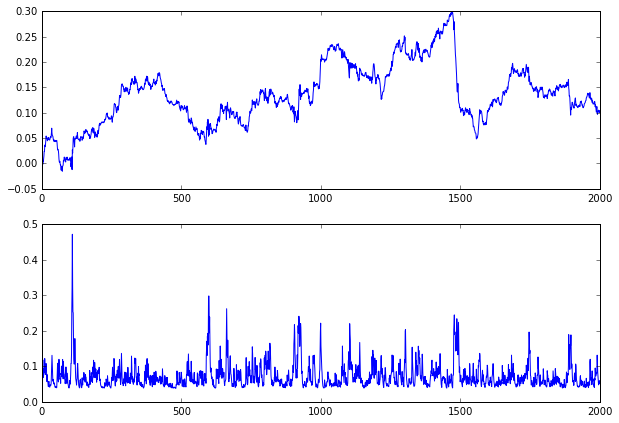

In [1097]:
plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(np.cumsum(train))
plt.subplot(2,1,2)
plt.plot(np.sqrt(trainvars)*math.sqrt(255))
plt.show()

In [1098]:
var_t = lvar
for eps in train[0:200,0]:
    var_t = kappa + alpha * var_t + beta * (eps*eps)
for eps in train[200:(200+look_back),0]:
    var_t = kappa + alpha * var_t + beta * (eps*eps)
    print(math.sqrt(var_t*255))

0.087109303516
0.0865325672587
0.0896294399398
0.0807029519857
0.0793087154556
0.097221277588
0.0731779687253
0.0596656104328
0.0641833625302
0.0581926598171
0.049507672563
0.0457504511755
0.0436083577727
0.0434791547818


In [1099]:
V.eval({I:trainX.transpose((0,2,1))[(200,),:,:].astype('float32')*F})*math.sqrt(255)/F

array([[ 0.07706274,  0.08305823,  0.08900163,  0.08133573,  0.08055441,
         0.0984611 ,  0.07494792,  0.06189479,  0.0662906 ,  0.06052362,
         0.05223538,  0.04869282,  0.04668766]], dtype=float32)

#### Compute the model Loss before training to insure loss goes down

In [1100]:
test_arr = trainX.transpose((0,2,1))[(200,),:,:].astype('float32')
ErrorStart = np.sum(Errors.eval({I:test_arr*F }))
print(ErrorStart)

13.0457


In [1101]:
print( modelT.predict(trainX.transpose((0,2,1))[(1,300),:,:]*F) )
print('-------------------------')
print( modelV.predict(trainX.transpose((0,2,1))[(200,),:,:]*F)*math.sqrt(255)/F )

[[ 0.54126602  3.74603319  1.50905347  0.9915328   1.30171633  1.6469444
   2.27721739  1.22850776  2.55205464  1.33912647  1.15490365  1.63668585
   1.78495228]
 [ 6.00483847  0.96944529  0.74845624  0.92367548  1.13600564  0.68253195
   0.88307881  2.83432722  1.04266798  0.73805994  1.13398933  0.97521269
   0.6992836 ]]
-------------------------
[[ 0.07706274  0.08305823  0.08900163  0.08133572  0.0805544   0.0984611
   0.07494792  0.06189479  0.0662906   0.06052362  0.05223538  0.04869282
   0.04668766]]


#### A few runs of training for sanity checks

In [1164]:
modelT.optimizer.lr.set_value(1e-2) # 1e-3 seems too large !
#modelT.optimizer.lr.get_value()

In [1165]:
Ydummy = trainX.transpose((0,2,1))[:,0:-1,0]
#print(Ydummy.shape)
hist0 = modelT.fit(trainX.transpose((0,2,1))*F, Ydummy, epochs=10, batch_size=64, verbose=0)

#### Compare Trained-Loss to check it did not worsen

In [1166]:
test_arr = trainX.transpose((0,2,1))[(200,),:,:].astype('float32')
ErrorEnd = np.sum(Errors.eval({I:test_arr*F}))
print(ErrorStart, ErrorEnd)

13.0457 13.1652


#### Compare long-term vol to check similarity

In [1167]:
math.sqrt(rnn.get_weights()[2][0]/(1-rnn.get_weights()[0][0][0]-rnn.get_weights()[1][0][0])*255)/F

0.0936233629592752

In [1168]:
kappa*F*F, rnn.get_weights()[2][0], rnn.get_weights()[0][0][0], rnn.get_weights()[1][0][0]

(0.10000000000000003, 0.15233715, 0.45356482, 0.41348198)

# Dummy code (for reference) to remove later on

In [74]:
idx = train

Xs = []
for l in range(lag):
    cdat = [idx[i+l] for i in xrange(0, len(idx)-1-lag, lag)]
    X = np.stack(cdat[:-2])
    Xs.append(X)

cdat = [idx[i+(l+1)] for i in xrange(0, len(idx)-1-lag, lag)]
Y = np.stack(cdat[:-2])

len(Xs), Xs[0].shape

(10, (197, 1))

In [80]:
modelUNR.optimizer.lr = 1e-2
dummy_Y = Xs[0]
hist1 = modelUNR.fit(Xs, dummy_Y, batch_size=40, nb_epoch=25)

Epoch 1/25
197/197 [==============================] - 0s - loss: -0.4572     
Epoch 2/25
197/197 [==============================] - 0s - loss: 0.5291     
Epoch 3/25
197/197 [==============================] - 0s - loss: 0.5669     
Epoch 4/25
197/197 [==============================] - 0s - loss: 0.5451     
Epoch 5/25
197/197 [==============================] - 0s - loss: 0.5021     
Epoch 6/25
197/197 [==============================] - 0s - loss: 0.4515     
Epoch 7/25
197/197 [==============================] - 0s - loss: 0.3993     
Epoch 8/25
197/197 [==============================] - 0s - loss: 0.3485     
Epoch 9/25
197/197 [==============================] - 0s - loss: 0.3007     
Epoch 10/25
197/197 [==============================] - 0s - loss: 0.2565     
Epoch 11/25
197/197 [==============================] - 0s - loss: 0.2160     
Epoch 12/25
197/197 [==============================] - 0s - loss: 0.1791     
Epoch 13/25
197/197 [==============================] - 0s - loss: 0.1454

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/engine/training.py:1393: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [27]:
lag = look_back

In [28]:
def show_top_next(mdl, inp, steps=1):
    inp = np.copy(inp)
    for k in range(steps):
        #ps = mdl.predict([np.array([i]) for i in inp])
        ps = mdl.predict(inp)
        newimp = np.concatenate((inp[0,:,:],ps), axis=1)
        inp[0,:,:] = newimp[:,1:]
    return inp

In [29]:
cut = 10
inps = [trainX[10:(cut+1),:,:], ]
for iter in range(8):
    inps.append( show_top_next(model, inps[-1], 5) )

print(inps[0])
print(inps[1])
print(inps[2])

[[[  2.88649919e-03  -2.74783844e-03   1.63140704e-05   3.59496255e-03
     1.68552216e-03]]]
[[[ 0.00037702 -0.00392252  0.00106558  0.00168964  0.00305192]]]
[[[-0.00242589 -0.00211503 -0.00037546  0.00334426  0.0013412 ]]]


In [13]:
TSmodel = np.concatenate(inps, axis=2)[0,0]
TSreal = trainX[range(cut,cut+5*len(inps),5),:,:].reshape((1,1,-1))[0,0]

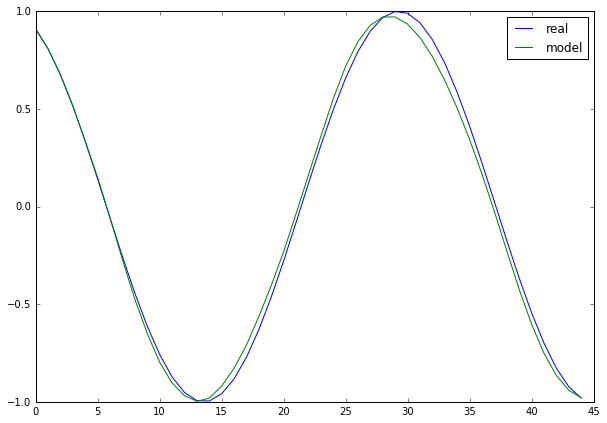

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(TSreal)
plt.plot(TSmodel)
plt.legend(['real','model'], loc='upper right')
plt.show()